In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [ ]:
path_img = Path('./brats_png/images')
path_lbl = Path('./brats_png/labels')

In [ ]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

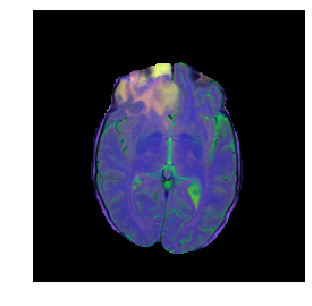

In [5]:
img_f = fnames[35]
img = open_image(img_f)
img.show(figsize=(5,5))

In [6]:
def get_y_fn(path):
    name = path.name
    return path_lbl/('mask_'+name)

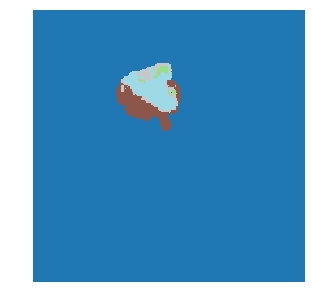

In [7]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [8]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([240, 240]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [9]:
codes = np.array(['0','1','2','3','4'], dtype='<U17')
len(list(codes))

5

In [10]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free} MB of GPU RAM free")

using bs=8, have 16119 MB of GPU RAM free


In [11]:
src = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct(.2)
        .label_from_func(get_y_fn, classes=codes))

In [12]:
src

LabelLists;

Train: LabelList (800 items)
x: SegmentationItemList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: SegmentationLabelList
ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240)
Path: brats_png/images;

Valid: LabelList (200 items)
x: SegmentationItemList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: SegmentationLabelList
ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240)
Path: brats_png/images;

Test: None

In [13]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [14]:
data

ImageDataBunch;

Train: LabelList (800 items)
x: SegmentationItemList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: SegmentationLabelList
ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120)
Path: brats_png/images;

Valid: LabelList (200 items)
x: SegmentationItemList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: SegmentationLabelList
ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120)
Path: brats_png/images;

Test: None

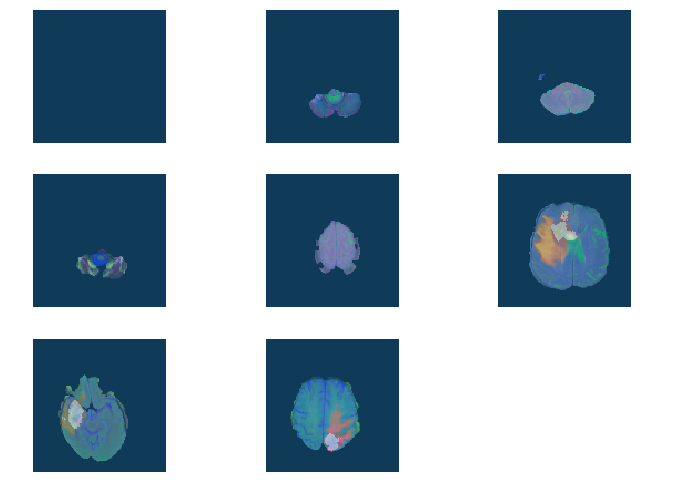

In [24]:
data.show_batch(4, figsize=(10,7))

This has no tumor:


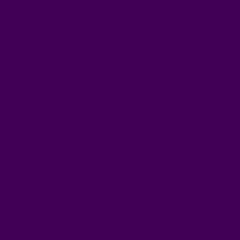

In [18]:
#What's our void code?
print('This has no tumor:')
ex_void_path = 'brats_png/labels/mask_pat131_0001_1.png'
open_mask(ex_void_path)

In [19]:
print('Void code == 0:')
np.unique(open_mask(ex_void_path).data)

Void code == 0:


array([0])

In [20]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['0']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

metrics=acc_camvid

In [21]:
wd=1e-2

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

'''
Already Ran - result is 1e-3:
'''
#lr_find(learn)
#learn.recorder.plot()

lr=3e-3

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 22943060.50it/s]


In [23]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.062999,0.052207,0.001270,00:17
1,0.046162,0.045504,0.101152,00:10
2,0.041117,0.040512,0.204146,00:10
3,0.040037,0.037436,0.150056,00:10
4,0.040256,0.050444,0.309187,00:11
5,0.045233,0.058449,0.139964,00:11
6,0.064149,0.043484,0.009232,00:10
7,0.038719,0.038701,0.098299,00:10
8,0.034756,0.042809,0.264560,00:11
9,0.030863,0.033590,0.228751,00:11


In [24]:
learn.save('stage-1')

In [26]:
learn.load('stage-1');

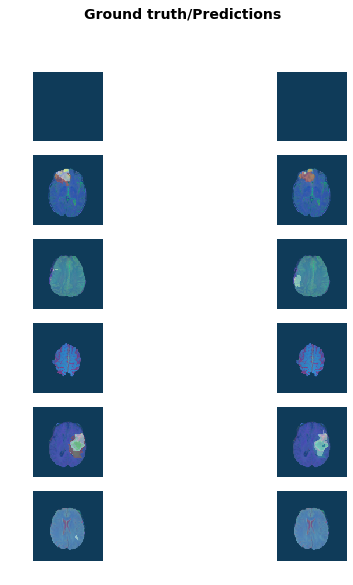

In [29]:
learn.show_results(rows=6, figsize=(8,9))